# Title

Import data from mongo to dataframe

Read US shapefile

Read demographic datasets 

Merge above together

Do analysis


In [1]:
# Import all the libraries required
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pymongo import MongoClient
import config

In [20]:
# TODO read datasets here, maybe filter a bit

# TODO read connection to pymongo
client = MongoClient(config.mongoConnectionString)
database = client[config.mongoDatabase]
processed_collection = database['processed']

tweets = processed_collection.find({})
df_tweets = pd.DataFrame(list(tweets))

# Reading geojson file
#geoFile = 'Datasets\states.geojson'
#world = gpd.read_file(geoFile)

,text
0,ALL IN COLLUSION TOGETHER #NOJUSTICE ...


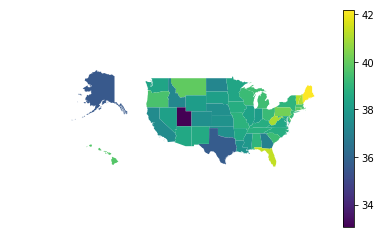

In [7]:
# Reading geojson file
geoFile = 'Datasets\states.geojson'
world = gpd.read_file(geoFile)

# changing the projection of reference system 
# TODO change to latlon!
world.crs = {'init' :'epsg:4269', 'no_defs': True}
world = world.to_crs({'init': 'epsg:3395'})

# join population data with geo data
world = world.merge(population_avg_age, how='inner', on='STATE_NAME')

# transforming and scaling hawaii and alaska
world.loc[world.STATE_NAME == 'Alaska', 'geometry'] = world[world.STATE_NAME == 'Alaska']['geometry']\
    .scale(xfact=0.4, yfact=0.4)\
    .translate(xoff = 0.15e7, yoff = -0.35e7)
world.loc[world.STATE_NAME == 'Hawaii', 'geometry'] = world[world.STATE_NAME == 'Hawaii']['geometry']\
    .scale(xfact=2, yfact=2)\
    .translate(xoff = 0.2e7, yoff = 0.10e7)

# Color the states
world.plot(column='avg_age2016', legend=True)
plt.axis('off')
#plt.legend(loc=2, prop={'size': 1}, labelspacing=0.1)
plt.show()
